In [1]:
import valenspy as vp
import valenspy
import importlib
importlib.reload(valenspy)
from valenspy.diagnostic import vp_TimeSeriesSpatialMean, vp_TemporalBias, vp_DailyCycleBias

from dask.diagnostics import ProgressBar
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

# ALARO_SFX - AEROSOL
Alaro sfx data with MERRA2 aerosol data

In [2]:
data_dir = Path("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX")
files = list(data_dir.glob("*.nc"))
files

[PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX/output_20060625.nc'),
 PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX/output_20060805.nc'),
 PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX/output_20060529.nc'),
 PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX/output_20060405.nc'),
 PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_EUROCORDEX/output_20060807.nc'),
 PosixPath('/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/6M_CObeII_ERA5_25_12_ALARO_SFX_E

In [4]:
ds_aero = xr.open_mfdataset(files, combine='by_coords', chunks="auto")

In [5]:
ds_aero_spatial_avg = ds_aero.mean(dim=["x","y"])

Currently the data is on a different grid so comparisons are only possible for spatially averaged data - note that even the domain is not exactly the same!

In [6]:
with ProgressBar():
    tas_aero = vp_TimeSeriesSpatialMean.apply(ds_aero_spatial_avg.temperature_2m_sfx).compute()

[########################################] | 100% Completed | 197.46 s


In [ ]:
with ProgressBar():
    ds_aero_spatial_avg = ds_aero[["temperature_2m_sfx","soil_moisture_top","soil_moisture_mid"]].mean(dim=["x","y"]).compute()

[########################################] | 100% Completed | 10m 37s


In [ ]:
with ProgressBar():
    ds_aero_temp_avg = ds_aero[["rain_stratiform","rain_convective","net_radiation"]].mean(dim=["time"]).compute()

[########################################] | 100% Completed | 12m 26s


In [13]:
with ProgressBar():
    ds_aero_spatial_avg = ds_aero[["temperature_2m_sfx","soil_moisture_top","soil_moisture_mid"]].mean(dim=["x","y"]).compute()

[########################################] | 100% Completed | 10m 37s


In [14]:
with ProgressBar():
    ds_aero_temp_avg = ds_aero[["rain_stratiform","rain_convective","net_radiation"]].mean(dim=["time"]).compute()

[########################################] | 100% Completed | 12m 26s


# ERA5

In [3]:
manager = vp.InputManager(machine='hortense')
ds_era = manager.load_data("ERA5",["pr","tas"], period=[2006,2006],freq="hourly",region="europe").sel(time=slice("2006-03-01","2006-09-30"))

File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-2006.nc
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/total_precipitation/era5-hourly-europe-total_precipitation-2006.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas', 'pr']


# Analysis

Ideally the data is ValEnsPy cf_complaint and this manual step does not have to happen. The ALARO_sfx input processor is currently not yet implemented.

Ideally one could use the Ensemble2Ref or Ensemble2Self functionality; however, as the data is not on the same grid, this is not possible.

### Time Series

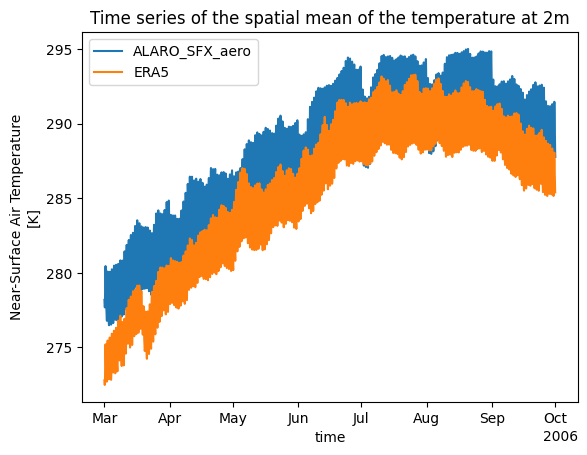

In [7]:
fig, ax = plt.subplots()
vp_TimeSeriesSpatialMean.visualize(tas_aero, ax=ax, label="ALARO_SFX_aero")
vp_TimeSeriesSpatialMean.visualize(vp_TimeSeriesSpatialMean.apply(ds_era.tas), ax=ax, label="ERA5")
ax.legend()
plt.title("Time series of the spatial mean of the temperature at 2m")
plt.show()

### Bias - Daily Cycle and time-series
Currently a warm bias

In [8]:
with ProgressBar():
    temp_bias = vp_TemporalBias.apply(tas_aero, ds_era.tas).compute()

[########################################] | 100% Completed | 4.51 sms


<Axes: title={'center': 'Time Series'}, xlabel='time'>

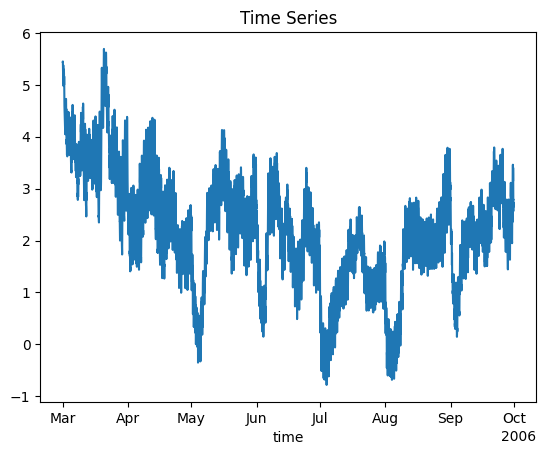

In [9]:
vp_TemporalBias.visualize(temp_bias)

In [10]:
with ProgressBar():
    daily_cycle_bias = vp_DailyCycleBias.apply(tas_aero, ds_era.tas).compute()

[########################################] | 100% Completed | 4.08 sms


<Axes: title={'center': 'Daily Cycle'}, xlabel='hour'>

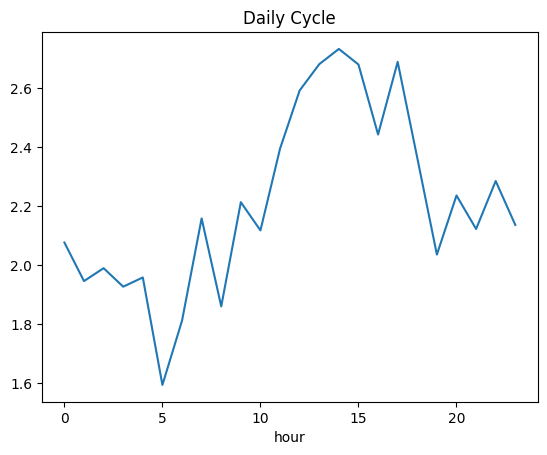

In [11]:
vp_DailyCycleBias.visualize(daily_cycle_bias)

### Soil moisture

This is worrying! It seems that the soil moisture is reset every month!

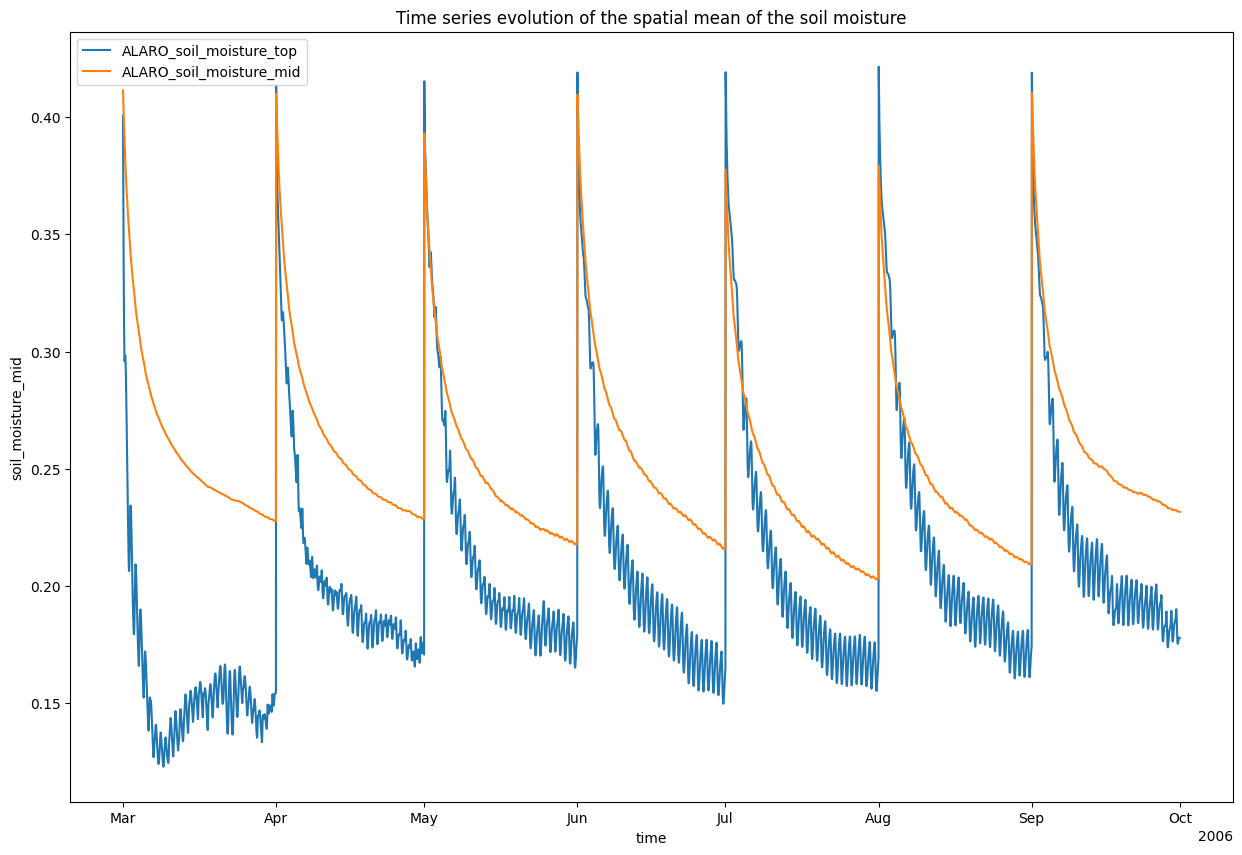

In [15]:
#Make a long plot
fig, ax = plt.subplots(figsize=(15,10))
vp_TimeSeriesSpatialMean.visualize(ds_aero_spatial_avg.soil_moisture_top, ax=ax, label="ALARO_soil_moisture_top")
vp_TimeSeriesSpatialMean.visualize(ds_aero_spatial_avg.soil_moisture_mid, ax=ax, label="ALARO_soil_moisture_mid")
ax.legend()
plt.title("Time series evolution of the spatial mean of the soil moisture")
plt.show()

### TODO
Investigate the soil moisture issue - It seems that this is replaced monthly (FAReplace) but should only be replaced over sea.
To check - if selecting a point over land if this phenomenon is still present.

In [ ]:
ds_aero_ukkel = ds_aero[["temperature_2m_sfx","soil_moisture_top","soil_moisture_mid"]].sel()

## Wouts (12km) data
Wouts 12km data for comparison

In [21]:
#Wouts data 
data_dir_w = "/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/CORDEXbeII/run_ALARO_sfx/out/netcdf/wout_12km_runs"
files_w = list(Path(data_dir_w).glob("*.nc"))

ds_wout = xr.open_mfdataset(files_w, combine='by_coords', chunks="auto")

In [22]:
with ProgressBar():
    ds_w_aero_spatial_avg = ds_wout[["temperature_2m_sfx","soil_moisture_top","soil_moisture_mid"]].mean(dim=["x","y"]).compute()

[########################################] | 100% Completed | 185.79 s


### Soil Moisture
Having a look at the soil moisture of Wouts data.

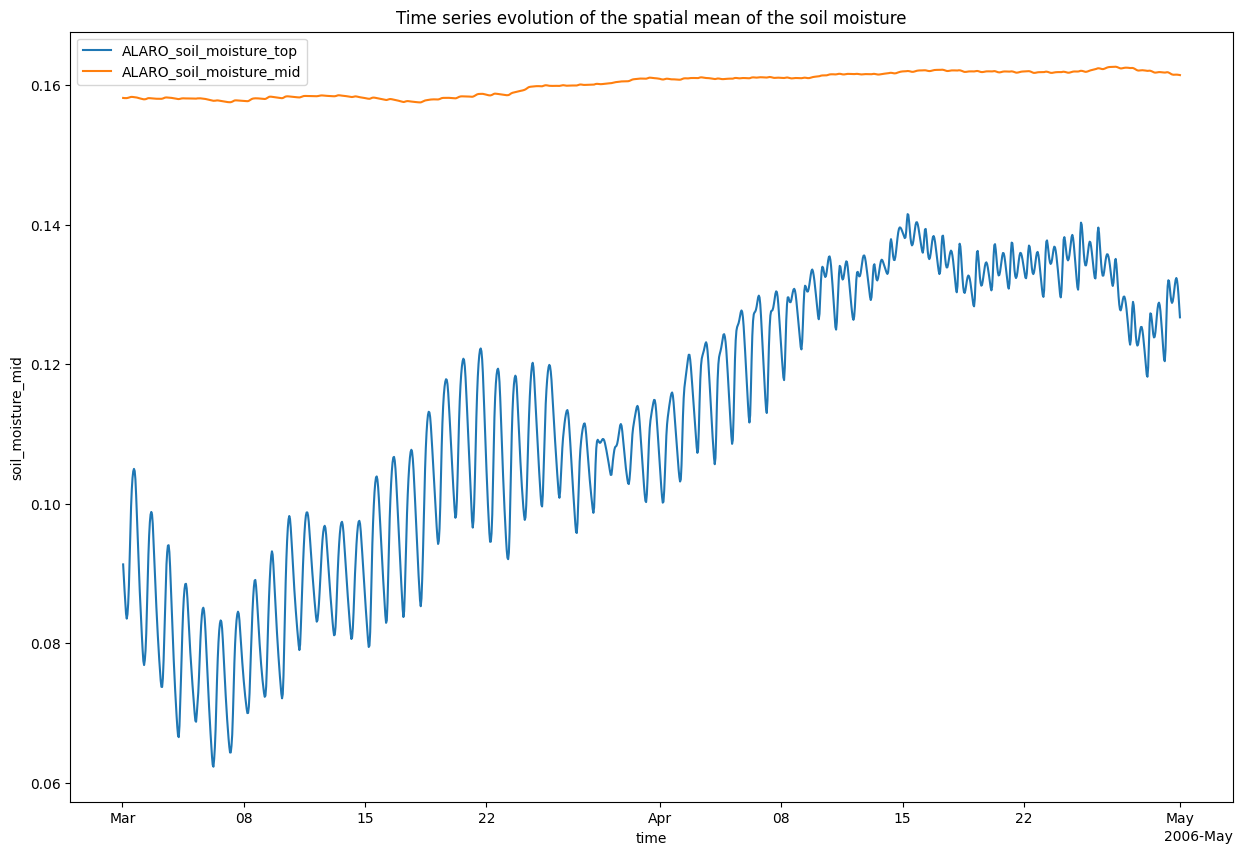

In [23]:
#Make a long plot
fig, ax = plt.subplots(figsize=(15,10))
vp_TimeSeriesSpatialMean.visualize(ds_w_aero_spatial_avg.soil_moisture_top, ax=ax, label="ALARO_soil_moisture_top")
vp_TimeSeriesSpatialMean.visualize(ds_w_aero_spatial_avg.soil_moisture_mid, ax=ax, label="ALARO_soil_moisture_mid")
ax.legend()
plt.title("Time series evolution of the spatial mean of the soil moisture")
plt.show()